# Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science.

#### Подключение библиотек и скриптов

In [986]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [987]:
import warnings
warnings.filterwarnings('ignore')

In [988]:
matplotlib.rcParams.update({'font.size': 14})

In [989]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Загрузка данных 

In [990]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Data is loaded!')

Data is loaded!


### Описание данных

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [991]:
print(f'Train: {train.shape[0]} строк и {train.shape[1]} признаков')
print(f'Test: {test.shape[0]} строк и {test.shape[1]} признаков')
train.shape[1] - 1 == test.shape[1]

Train: 10000 строк и 20 признаков
Test: 5000 строк и 19 признаков


True

### Оптимизация занимаемой памяти

In [992]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [993]:
train = optimizing_df(train)
test = optimizing_df(test)

In [994]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [995]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


### Приведение типов

In [996]:
train.dtypes

Id                 uint16
DistrictId          uint8
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor               uint8
HouseFloor        float32
HouseYear          uint32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1            uint8
Social_2           uint16
Social_3            uint8
Healthcare_1      float32
Helthcare_2         uint8
Shops_1             uint8
Shops_2          category
Price             float32
dtype: object

In [997]:
train[['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']] = train[['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']].astype(str)

In [998]:
train.dtypes

Id                object
DistrictId         uint8
Rooms            float32
Square           float32
LifeSquare       float32
KitchenSquare    float32
Floor              uint8
HouseFloor       float32
HouseYear         uint32
Ecology_1        float32
Ecology_2         object
Ecology_3         object
Social_1           uint8
Social_2          uint16
Social_3           uint8
Healthcare_1     float32
Helthcare_2        uint8
Shops_1            uint8
Shops_2           object
Price            float32
dtype: object

In [999]:
test[['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']] = test[['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']].astype(str)

In [1000]:
test.dtypes

Id                object
DistrictId         uint8
Rooms            float32
Square           float32
LifeSquare       float32
KitchenSquare    float32
Floor              uint8
HouseFloor       float32
HouseYear         uint16
Ecology_1        float32
Ecology_2         object
Ecology_3         object
Social_1           uint8
Social_2          uint16
Social_3           uint8
Healthcare_1     float32
Helthcare_2        uint8
Shops_1            uint8
Shops_2           object
dtype: object

#### Целевая переменная

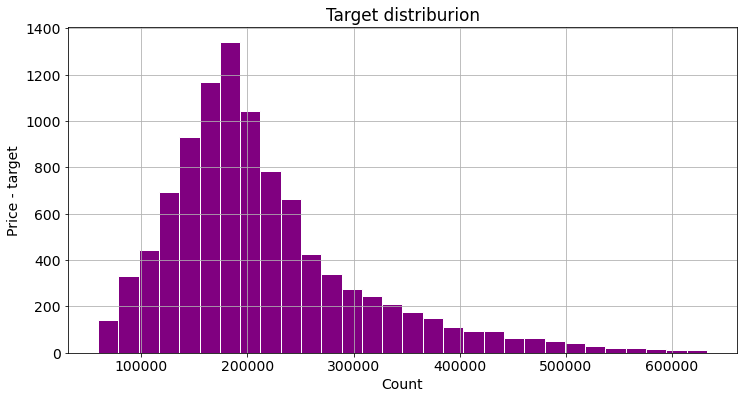

In [1001]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.hist(train['Price'], bins = 30, color = 'purple', ec = 'white')
plt.xlabel('Count')
plt.ylabel('Price - target')
ax.grid()
fig.set_size_inches(12,6)

plt.title('Target distriburion')
plt.show()



#### Количественные переменные

In [1002]:
train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,43.587592,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


#### Номинативные переменные

In [1003]:
train.select_dtypes(include = 'object').columns.tolist()

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [1004]:
train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
205      1
174      1
209      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [1005]:
train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [1006]:
train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [1007]:
train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

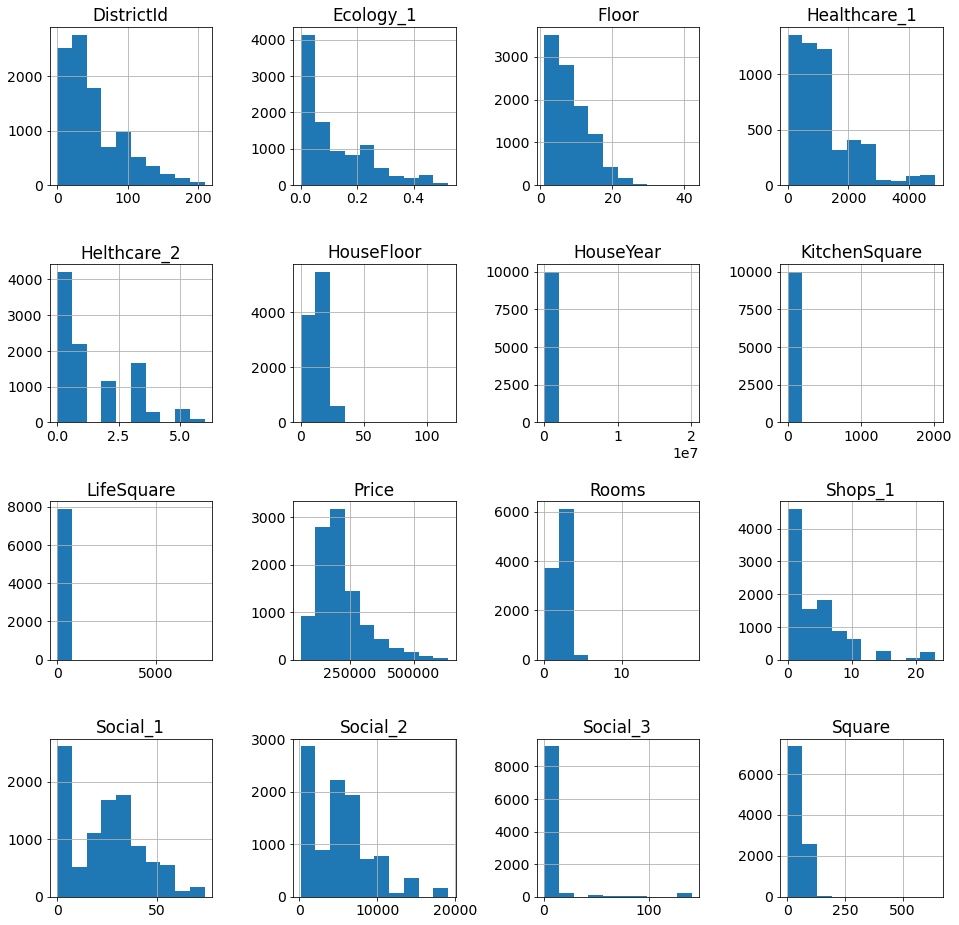

In [1008]:
feat_numeric = list(train.select_dtypes(exclude='object').columns)
train[feat_numeric].hist(figsize=(16,16))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

##### Rooms

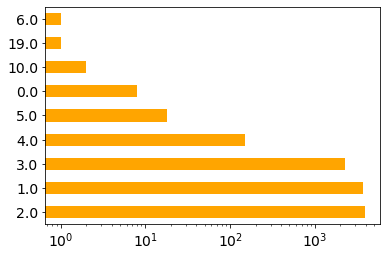

In [1009]:
train['Rooms'].value_counts().plot(kind = 'barh', logx = True, color = 'orange')

In [1010]:
info_by_district_id = train.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_rooms_dr', 'Square': 'sum_square_dr'})

info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] \
        / info_by_district_id['sum_rooms_dr']
info_by_district_id.drop(['sum_square_dr', 'sum_rooms_dr'], axis=1, inplace=True)

train = train.merge(info_by_district_id, on=['DistrictId', 'HouseYear'], how='left')

train['mean_square_per_room_in_dr'] = train['mean_square_per_room_in_dr'].fillna(train['mean_square_per_room_in_dr'].mean())

train.loc[train['Rooms'] > 5, 'Rooms'] = (train.loc[train['Rooms'] > 5, 'Square'] // train.loc[train['Rooms'] > 5, 'mean_square_per_room_in_dr'])\
        .astype('int')

train.loc[train['Rooms'] == 0, 'Rooms'] = (train.loc[train['Rooms'] == 0, 'Square'] \
           // train.loc[train['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')

train.loc[train['Rooms'] == 0, 'Rooms'] = 1

train.drop('mean_square_per_room_in_dr', axis=1, inplace=True)

#train.loc[train['Rooms'] == 0, 'Rooms'] = 1
#train.loc[train['Rooms'] >= 6, 'Rooms'] = train['Rooms'].median()
#train['Rooms'].value_counts()

##### KitchenSquare

In [1011]:
train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
41.0         2
112.0        2
25.0         2
43.0         2
51.0         2
37.0         2
32.0         2
30.0         2
58.0         2
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
62.0         1
42.0         1
63.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
53.0         1
54.0         1
Name: KitchenSquare, dtype: int64

In [1012]:
train['KitchenSquare'].quantile(.975), train['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [1013]:
condition = (train['KitchenSquare'].isna()) | (train['KitchenSquare'] > train['KitchenSquare'].quantile(.99)) |\
                    (train['KitchenSquare'] < train['KitchenSquare'].quantile(.01))
train.loc[condition, 'KitchenSquare'] = train['KitchenSquare'].median()
train.loc[train['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [1014]:
train['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
5.0     1169
6.0     1129
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
4.0       39
15.0      31
16.0      16
Name: KitchenSquare, dtype: int64

##### Square, LifeSquare

In [1015]:
train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.888500,56.315712,37.199596,6.322900,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,43.587592,0.811742,21.058718,86.241112,2.915533,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,1.000000,1.136859,0.370619,3.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,22.769833,3.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,209.000000,5.000000,641.065186,7480.592285,16.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [1016]:
# Обработаем признак LifeSquare
condition = (train['LifeSquare'].isna()) | (train['LifeSquare'] > train['LifeSquare'].quantile(.99)) |\
                    (train['LifeSquare'] < train['LifeSquare'].quantile(.01))

train.loc[condition, 'LifeSquare'] = train['LifeSquare'].median()
train.loc[train['LifeSquare'] < 10, 'LifeSquare'] = 10

train.loc[train['Square'] < train['LifeSquare'],
           'LifeSquare'] = train.loc[train['Square'] < train['LifeSquare'], 'Square']

In [1017]:
# Обработаем признак Square
condition = (train['Square'].isna()) | (train['Square'] > train['Square'].quantile(.99)) |\
                    (train['Square'] < train['Square'].quantile(.01))
train.loc[condition, 'Square'] = train['Square'].median()

##### House Floor, Floor

In [1018]:
train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [1019]:
train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=uint8)

In [1020]:
train.loc[train['HouseFloor'] == 0, 'HouseFloor'] = train['HouseFloor'].median()

In [1021]:
floor_outliers = train[train['Floor'] > train['HouseFloor']].index
train.loc[floor_outliers, 'Floor'] = train.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

##### HouseYear

In [1022]:
train['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
1499        2020
5701        2020
7076        2020
          ...   
7611        1916
910         1914
5111        1912
2656        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: uint32

In [1023]:
# 2 существенных выброса!
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] = (2005+2011) // 2
train.loc[train['HouseYear'] == 4968, 'HouseYear'] = 1968

In [1024]:
train['HouseYear'].unique()

array([1969, 1978, 1968, 1977, 1976, 2011, 1960, 2014, 1973, 1959, 1999,
       1980, 1979, 1983, 2001, 2012, 2002, 1996, 1964, 2018, 1972, 1965,
       1984, 1961, 1971, 1963, 2017, 1970, 1981, 2003, 2016, 1991, 1975,
       2006, 2009, 1985, 1974, 1994, 2000, 1987, 1998, 2005, 1990, 1982,
       1997, 2015, 2008, 2010, 2004, 2007, 1967, 1957, 1962, 1993, 1966,
       1955, 1937, 1992, 1954, 1995, 2019, 1948, 1986, 2013, 1989, 1958,
       1938, 1956, 1988, 2020, 1951, 1952, 1935, 1914, 1932, 1950, 1917,
       1918, 1940, 1942, 1939, 1934, 1931, 1919, 1912, 1953, 1936, 1947,
       1929, 1930, 1933, 1941, 1916, 1910, 1928], dtype=uint32)

### Обработка пропусков

In [1025]:
len(train) - train.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [1026]:
# Видим существенное количество пропущенных значений в признаке Lifesquare и Healthcare_1
train[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981560,29.442751,6.0
1,65.683640,40.049541,8.0
2,44.947952,29.197611,3.0
3,53.352982,52.731510,9.0
4,39.649193,23.776169,7.0
5,80.384476,46.683720,12.0
6,62.254112,37.160378,7.0
7,80.312927,32.781261,3.0
8,64.511436,32.781261,3.0
9,46.461411,18.915552,8.0


##### LifeSquare

In [1027]:
additional_square = (train.loc[train['Square'].notnull(), 'Square'] -  \
                    train.loc[train['LifeSquare'].notnull(), 'LifeSquare'] - \
                    train.loc[train['KitchenSquare'].notnull(), 'KitchenSquare']).median()
additional_square

12.155824661254883

In [1028]:
train.loc[train['LifeSquare'].isnull(), 'LifeSquare'] =\
train.loc[train['LifeSquare'].isnull(), 'Square'] -\
train.loc[train['LifeSquare'].isnull(), 'KitchenSquare'] -\
additional_square

In [1029]:
train['LifeSquare'].isnull().sum()

0

##### Healthcare_1

In [1030]:
train['Healthcare_1'].head()

0       NaN
1     240.0
2     229.0
3    1084.0
4    2078.0
Name: Healthcare_1, dtype: float32

In [1031]:
train.loc[train['Healthcare_1'].isnull(), 'Healthcare_1'] = train['Healthcare_1'].median()

### Построение новых признаков

In [1032]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,900.0,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


#### Dummies

In [1033]:
train['Ecology_2_bin'] = train['Ecology_2'].replace({'A':0, 'B':1})
train['Ecology_3_bin'] = train['Ecology_3'].replace({'A':0, 'B':1})
train['Shops_2_bin'] = train['Shops_2'].replace({'A':0, 'B':1})

In [1034]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,900.0,0,11,B,184966.937500,1,1,1
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.437500,1,1,1
2,4765,53,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.906250,1,1,1
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.234375,1,1,1
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531250,1,1,1


#### Добавление нового признака MedPriceByDistrict

In [1035]:
med_price_by_district = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [1036]:
train = train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,MedPriceByDistrict
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,5,900.0,0,11,B,184966.937500,1,1,1,207786.125000
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.437500,1,1,1,300009.437500
2,4765,53,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,...,0,229.0,1,3,B,220925.906250,1,1,1,263206.218750
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.234375,1,1,1,166809.671875
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531250,1,1,1,158539.062500


### Отбор признаков

In [1037]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'MedPriceByDistrict']

### Матрица корреляций

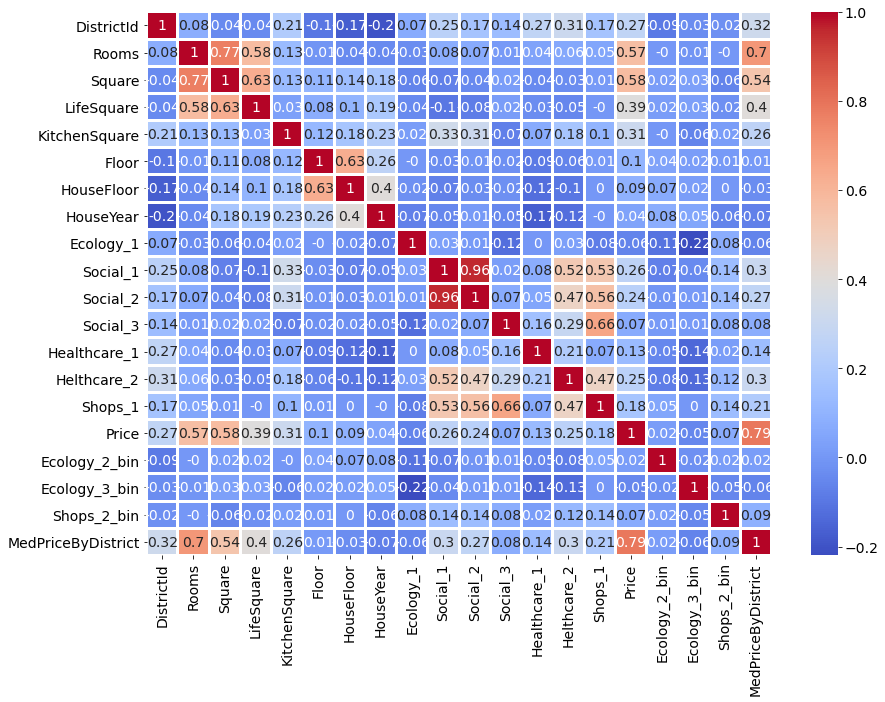

In [1038]:
corr_matrix = train.corr()
corr_matrix = np.round(corr_matrix,2)
plt.figure(figsize = (14,10))
sns.heatmap(corr_matrix, annot=True, linewidth = 2, cmap = 'coolwarm')

При исключении параметров,коэффициент корреляции которых менее 0,2 с Price - результат ухудшается.

#### Оценка корреляции каждого признака с целевой переменной (Price)

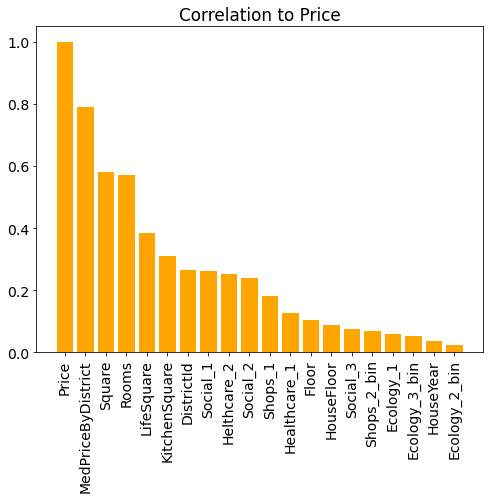

In [1039]:
corr_matrix = train.corrwith(train['Price'])
corr_matrix = train.loc[:, train.columns != 'Id'].corrwith(train['Price']).abs().sort_values(ascending=False)
plt.figure(figsize = (8, 6))
plt.bar(corr_matrix.index, corr_matrix.values, color = 'orange')
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

### Зависимость таргета (Price) от отдельных признаков

Text(0.5, 1.0, 'Distribution of variable District Id')

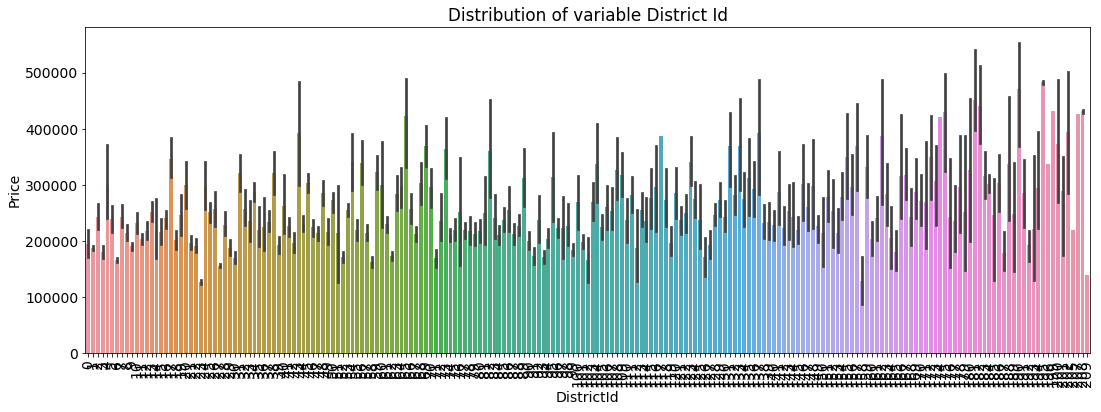

In [1040]:
plt.figure(figsize=(18, 6))
sns.barplot(train['DistrictId'], train['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable District Id')

Text(0.5, 1.0, 'Distribution of variable District Id')

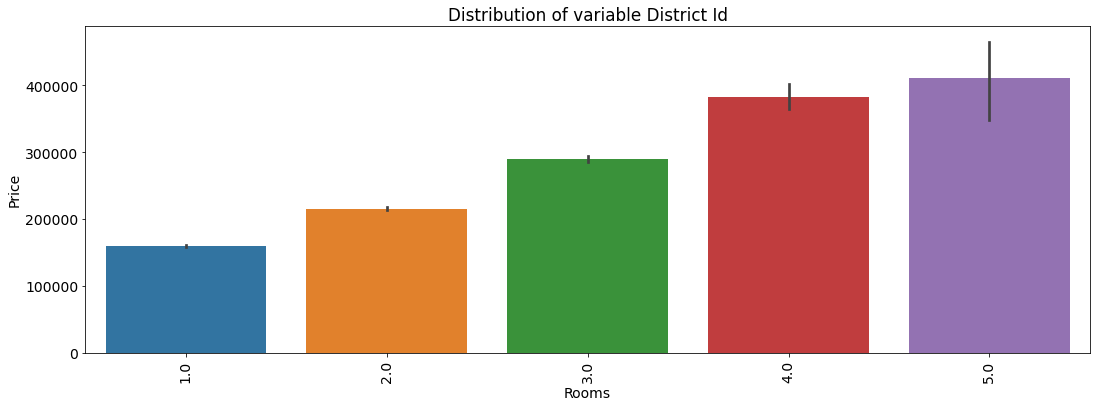

In [1041]:
plt.figure(figsize=(18, 6))
sns.barplot(train['Rooms'], train['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable District Id')

Text(0.5, 1.0, 'Distribution of variable District Id')

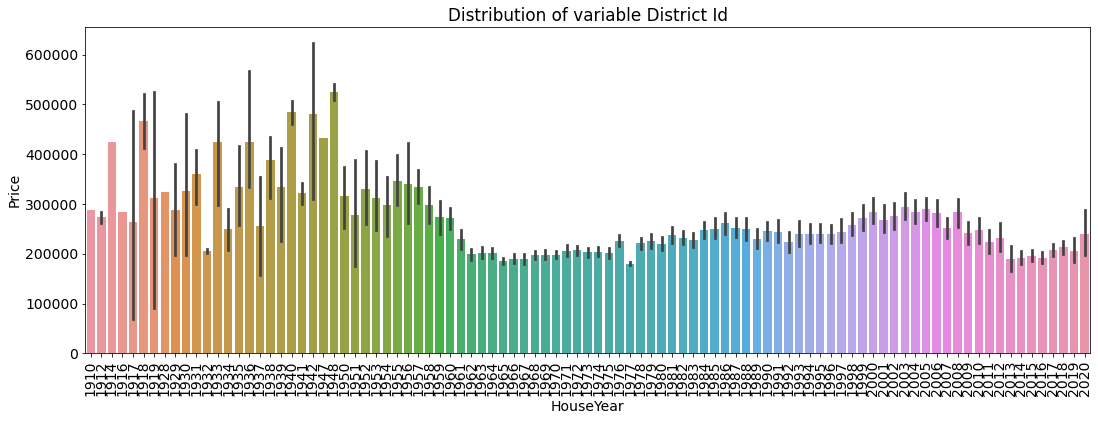

In [1042]:
plt.figure(figsize=(18, 6))
sns.barplot(train['HouseYear'], train['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable District Id')

In [1043]:
#feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 #'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                 #'Healthcare_1', 'Helthcare_2']
feature_names = ['DistrictId','Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['MedPriceByDistrict']

target_name = 'Price'

### Разбиение на train и test

In [1044]:
X = train[feature_names + new_feature_names]
y = train[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение модели и выбор лучшей

##### Линейная регрессия

Train R2:	0.69
Test R2:	0.697


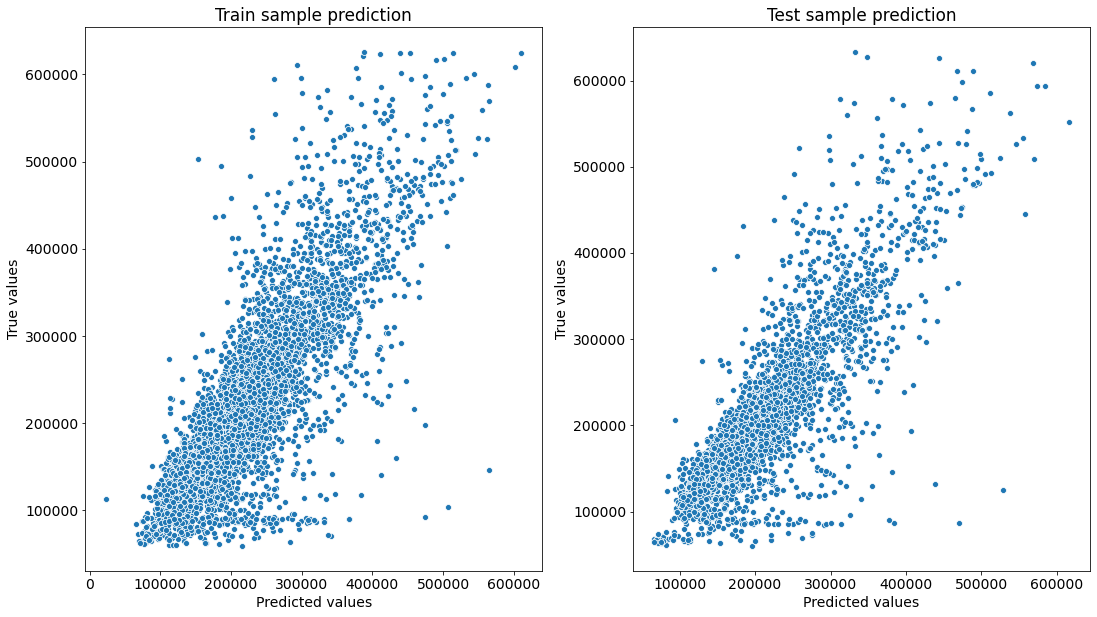

In [1045]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

evaluate_preds(y_train, y_train_pred, y_test, y_test_pred)

##### RandomForest

In [1100]:
rf_model = RandomForestRegressor()

parametres_rf = {
    'n_estimators': [150, 200, 250],
    'max_features': [5,7,9],
    'max_depth': [7,9,11]
}

clf_rf = GridSearchCV (
            estimator = rf_model,
            param_grid = parametres_rf,
            scoring = 'r2',
            cv = KFold (n_splits = 3, random_state = 21, shuffle = True)
)

In [1101]:
clf_rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [7, 9, 11], 'max_features': [5, 7, 9],
                         'n_estimators': [150, 200, 250]},
             scoring='r2')

In [1103]:
clf_rf.best_params_

{'max_depth': 11, 'max_features': 7, 'n_estimators': 250}

Train R2:	0.895
Test R2:	0.762


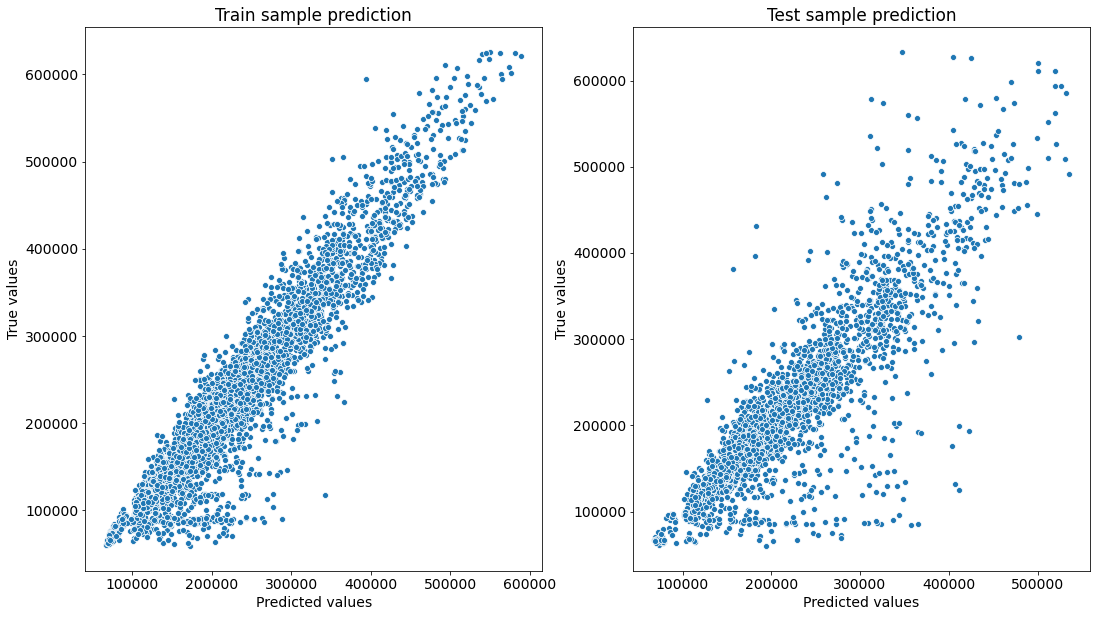

In [1096]:
rf_model = RandomForestRegressor(max_depth=11, max_features=7, n_estimators=250)
rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

##### Перекрестная проверка

In [1099]:
cv_score_rf = cross_val_score(gb_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score_rf

array([0.77674896, 0.73664945, 0.7314274 , 0.76735268, 0.75071072])

In [1051]:
cv_score_rf.mean()

0.75109964023975

In [1110]:
r2_train_rf = r2(y_train, y_train_pred_rf)
r2_test_rf = r2(y_test, y_test_pred_rf)

#### GradientBoostingRegressor

In [1052]:
# при тестировании моделей, GradientBoosting дал наилучший результат
gb_model = GradientBoostingRegressor()

In [1053]:
parametres_gb = {
    'n_estimators': [100, 150, 170],
    'max_depth': [3, 5, 7]
}

clf_gb = GridSearchCV (
            estimator = gb_model,
            param_grid = parametres_gb,
            scoring = 'r2',
            cv = KFold (n_splits = 3, random_state = 21, shuffle = True)
)

In [1054]:
clf_gb.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [100, 150, 170]},
             scoring='r2')

In [1055]:
clf_gb.best_params_

{'max_depth': 5, 'n_estimators': 100}

Train R2:	0.873
Test R2:	0.758


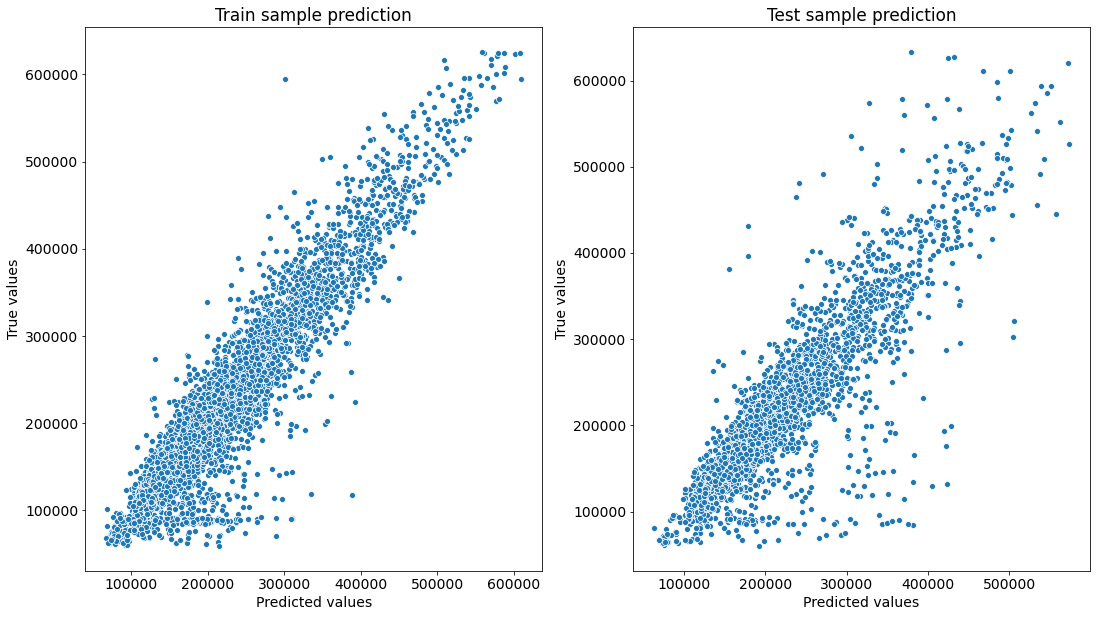

In [1084]:
gb_model = GradientBoostingRegressor(max_depth=5, n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

evaluate_preds(y_train, y_train_pred_gb, y_test, y_test_pred_gb)

##### Перекрестная проверка

In [1057]:
cv_score_gb = cross_val_score(gb_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score_gb

array([0.76167558, 0.73876174, 0.75509305])

In [1058]:
cv_score_gb.mean()

0.7518434561191453

In [1117]:
r2_train_gb = r2(y_train, y_train_pred_gb)
r2_test_gb = r2(y_test, y_test_pred_gb)

##### Сравнение моделей, которые дали наилучший результат

In [1121]:
compare_models = pd.DataFrame({'train_r2': [r2_train_rf, r2_train_gb],
                             'test_r2': [r2_test_rf, r2_test_gb]}, index = ['RandomForest', 'GradientBoorting'])
compare_models

,train_r2,test_r2
RandomForest,0.895267,0.762268
GradientBoorting,0.873066,0.758052


Линейная регрессия дала значительно меньший результат, ее не берем в сравнение.
Сравнивая RandomForest и GradientBoosting, предпочтение отдаем RandomForest, его показатели незначительно превышают GradientBoosting

#### Важность признаков


In [1059]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MedPriceByDistrict,0.682824
2,Square,0.103146
6,HouseFloor,0.029862
7,HouseYear,0.028838
3,LifeSquare,0.022236
13,Social_3,0.020540
4,KitchenSquare,0.019910
14,Healthcare_1,0.014872
12,Social_2,0.014426
0,DistrictId,0.013858


### ТЕСТОВЫЙ ДАТАСЕТ

##### Обработка тестового датасета на основе тренировочного
#### Обработка выбросов

In [1060]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [1061]:
test['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [1062]:
info_by_district_id = test.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_rooms_dr', 'Square': 'sum_square_dr'})

info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] \
        / info_by_district_id['sum_rooms_dr']
info_by_district_id.drop(['sum_square_dr', 'sum_rooms_dr'], axis=1, inplace=True)

test = test.merge(info_by_district_id, on=['DistrictId', 'HouseYear'], how='left')

test['mean_square_per_room_in_dr'] = test['mean_square_per_room_in_dr'].fillna(test['mean_square_per_room_in_dr'].mean())

test.loc[test['Rooms'] > 5, 'Rooms'] = (test.loc[test['Rooms'] > 5, 'Square'] // test.loc[test['Rooms'] > 5, 'mean_square_per_room_in_dr'])\
        .astype('int')

test.loc[test['Rooms'] == 0, 'Rooms'] = (test.loc[test['Rooms'] == 0, 'Square'] \
           // test.loc[test['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')

test.loc[test['Rooms'] == 0, 'Rooms'] = 1

test.drop('mean_square_per_room_in_dr', axis=1, inplace=True)

#test.loc[test['Rooms'] == 0, 'Rooms'] = 1
#test.loc[test['Rooms'] >= 6, 'Rooms'] = test['Rooms'].median()
#test['Rooms'].value_counts()

In [1063]:
test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,51.279200,1.908200,56.449501,36.158760,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657227,1.31940,4.242800
std,44.179466,0.810379,19.092793,17.825277,9.950147,5.483228,6.789167,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744995,1.47994,4.777365
min,0.000000,1.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,41.906230,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921339,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,66.285130,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,212.000000,6.000000,223.453690,303.071106,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [1064]:
condition = (test['KitchenSquare'].isna()) | (test['KitchenSquare'] > test['KitchenSquare'].quantile(.99)) |\
                    (test['KitchenSquare'] < test['KitchenSquare'].quantile(.01))
test.loc[condition, 'KitchenSquare'] = test['KitchenSquare'].median()
test.loc[train['KitchenSquare'] < 3, 'KitchenSquare'] = 3

condition = (test['LifeSquare'].isna()) | (test['LifeSquare'] > test['LifeSquare'].quantile(.99)) |\
                    (train['LifeSquare'] < test['LifeSquare'].quantile(.01))

test.loc[condition, 'LifeSquare'] = test['LifeSquare'].median()
test.loc[train['LifeSquare'] < 10, 'LifeSquare'] = 10

condition = (test['Square'].isna()) | (test['Square'] > test['Square'].quantile(.99)) |\
                    (test['Square'] < test['Square'].quantile(.01))
test.loc[condition, 'Square'] = test['Square'].median()

test.loc[test['Square'] < test['LifeSquare'],
           'LifeSquare'] = test.loc[test['Square'] < test['LifeSquare'], 'Square']

In [1065]:
test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,51.279200,1.908200,55.915539,34.650642,5.639000,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657227,1.31940,4.242800
std,44.179466,0.810379,16.731903,13.657537,3.719112,5.483228,6.789167,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744995,1.47994,4.777365
min,0.000000,1.000000,30.062519,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,42.184767,25.811338,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921341,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,65.802452,40.824353,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,212.000000,6.000000,115.553131,90.448631,15.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [1066]:
test['HouseYear'].sort_values(ascending=False)

4389    2020
4273    2020
888     2020
3255    2020
1039    2020
        ... 
1475    1912
64      1911
2691    1910
2       1909
3253    1908
Name: HouseYear, Length: 5000, dtype: uint16

In [1067]:
test['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.], dtype=float32)

In [1068]:
test['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78], dtype=uint8)

In [1069]:
test.loc[test['HouseFloor'] == 0, 'HouseFloor'] = test['HouseFloor'].median()

In [1070]:
floor_outliers = test[test['Floor'] > test['HouseFloor']].index

test.loc[floor_outliers, 'Floor'] = test.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

#### Обработка пропущенных значений

In [1071]:
test.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [1072]:
# Обрабатываем пропущенные значение по признаку Heathcare_1
test.loc[test['Healthcare_1'].isnull(), 'Healthcare_1'] = test['Healthcare_1'].median()

In [1073]:
test['Healthcare_1'].isnull().sum()

0

### Генерация новых признаков

In [1074]:
#Дамми
test['Ecology_2_bin'] = test['Ecology_2'].replace({'A':0, 'B':1})
test['Ecology_3_bin'] = test['Ecology_3'].replace({'A':0, 'B':1})
test['Shops_2_bin'] = test['Shops_2'].replace({'A':0, 'B':1})
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,...,11,2748,1,900.0,0,0,B,1,1,1
1,15856,74,2.0,69.263184,32.925087,1.0,1,1.0,1977,0.075779,...,6,1437,3,900.0,0,2,B,1,1,1
2,5480,190,1.0,52.921341,15.948246,12.0,2,5.0,1909,0.000000,...,30,7538,87,4702.0,5,5,B,1,1,1
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,...,23,4583,3,900.0,3,3,B,1,1,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,2,629,1,900.0,0,0,A,1,1,0


In [1075]:
test = test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [1076]:
#Устанавливаем в пропущенные значения среднюю стоимость по количеству комнат в квартире
test.loc[(test['MedPriceByDistrict'].isnull() & test['Rooms'] == 1), 'MedPriceByDistrict'] =\
(test.loc[test['Rooms'] == 1, 'MedPriceByDistrict']).median()
test.loc[(test['MedPriceByDistrict'].isnull() & test['Rooms'] == 2), 'MedPriceByDistrict'] =\
(test.loc[test['Rooms'] == 2, 'MedPriceByDistrict']).median()
test.loc[(test['MedPriceByDistrict'].isnull() & test['Rooms'] == 3), 'MedPriceByDistrict'] =\
(test.loc[test['Rooms'] == 3, 'MedPriceByDistrict']).median()
test.loc[(test['MedPriceByDistrict'].isnull() & test['Rooms'] == 4), 'MedPriceByDistrict'] =\
(test.loc[test['Rooms'] == 4, 'MedPriceByDistrict']).median()

In [1077]:
(test['MedPriceByDistrict'].isnull()).sum()

0

In [1078]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   object 
 1   DistrictId          5000 non-null   uint8  
 2   Rooms               5000 non-null   float32
 3   Square              5000 non-null   float32
 4   LifeSquare          5000 non-null   float32
 5   KitchenSquare       5000 non-null   float32
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float32
 8   HouseYear           5000 non-null   uint16 
 9   Ecology_1           5000 non-null   float32
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   uint8  
 13  Social_2            5000 non-null   uint16 
 14  Social_3            5000 non-null   uint8  
 15  Healthcare_1        5000 non-null   float32
 16  Helthc

In [1085]:
test_final = test[feature_names + new_feature_names]

### Модель RandomForest дала лучший результат, имеенно по нему делаем прогноз

In [1097]:
test['Price'] = rf_model.predict(test_final)

In [1098]:
test[['Id', 'Price']].to_csv('AleksandrinaViatkinaCourseProject_2.csv', index=None)

In [1092]:
test['Price'].shape

(5000,)